In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

from fastbook import *

# Collaborative Filtering Deep Dive

Birden fazla kullanıcım ve ürünüm var diyelim, hangi ürünü hangi müşteriye temsil etmeliyim yani hangi müşteri hangi ürünü beğenir, alır sorusunu cevaplamak istiyorum. Bu probleme verilecek örnekler çok, örneğin Netflix üzerinden film önermesi, anasayfada hangi kullanıcıya ne önermeliyim? Instagramda hangi kullanıcıya ne göstermeliyim?

"Collaborative Filtering" bu problemi çözmek için şu yaklaşımı kullanıyor, örneğin X kulanıcısına önerme yapmak istiyorum, kullanıcının hali hazırda neleri beğendiğini buluruz Y ürünleri diyelim, daha sonra Y ürünlerini beğenen diğer kullanıcıları buluruz, son olarak da bu diğer kullanıcıların Y dışında beğendiklerini X kullanıcısna öneririz.


Aslında olay şu, datasetimizdeki her kullanıcıya ve her ürüne bir embedding matrix atıyoruz, daha sonra modelimiz bir kullanıcının bir ürüne vereceği puanı hesaplarken ilgili embedding vector'leri çarpıyor sonuçta ne olacak doğru tahminler bulabilmesi için her kişi ve her ürün için doğru embedding vector'lerin oluşması lazım bu embeddings de aslında kullanıcı taste profili ve ürün characteristics olarak yorumlanabilir.

Yani diyelim ki ben 1970 yapımı science fiction'lara bayılıyorum bu genre'ya ve benim gibi bir çok insan var, modelimiz aslında filmle ilgili hiçbir şey bilmemesine rağmen, bazı insanların bu filme tam puan verdiğini doğru tahmin edebilmesi için şunun ayırdına varması şart: "yahu bu filmde bi olay var normal şekilde sonucu tahmin edemiyorum ben o yüzden embedding'in içinde bu genre'yı kodlayayım"; benzer şekilde kullanıcı için de "yahu bu kullanıcı şu genre için iyi puan veriyor o zaman ben bu kullanıcının taste profiline bunu kodlayayım" sonuçta artık bu ilgili filmin embeding vector'ü içinde filmin genre'sı bir şekilde gömülü, benzer şekilde bu filme seven kullanıcıların embedding vector'u da bir taste profile temsil ediyor.

Diyelim ki görece yeni bir film çıktı ve 1970 yapımı bir science fiction, bu genre'yı sevenler hep yüksek puan verdi, o zaman o filmin vector'üne genre kodlanmış oldu, o halde artık ben bu filmi ilgili genre'yı seven herkese önerebilirim.

Bu problemde "cold start" sıkıntısı olduğunu unutma yani hiçbir filmi rate'lememiş bir kullanıcı için veya hiçkimse tarafından izlenmemiş bir film için embeddings oluşturulamaz. 

##### Kavramları İrdeleyelim

Movies, veya products yerine **items** kullanılması daha doğru. Çünkü bu **items** tıklanan linkler olabilir, hastaların diagnosis'i olabilir vesaire.

Embedding vectors'den de **latent factors** olarak bahsedilecek.


#### Şimdi Movie Recommendation Problemini Ele Alalım:

## A First Look at the Data

MovieLens kullanılacak. Bu dataset 10m movie ranking içeriyor (Movie ID, User ID, Rating). Biz burada 100k'lık bir subset kullanacağız. Full dataset websitesinden ulaşılabilir.

Dataset'e usual şekilde ulaşıyoruz:

In [2]:
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

In [3]:
path

Path('/storage/data/ml-100k')

In [4]:
path.ls()

(#23) [Path('/storage/data/ml-100k/u4.test'),Path('/storage/data/ml-100k/u1.base'),Path('/storage/data/ml-100k/u4.base'),Path('/storage/data/ml-100k/u.info'),Path('/storage/data/ml-100k/u2.base'),Path('/storage/data/ml-100k/README'),Path('/storage/data/ml-100k/u.item'),Path('/storage/data/ml-100k/u.data'),Path('/storage/data/ml-100k/u5.test'),Path('/storage/data/ml-100k/u5.base')...]

Asıl tablomuz u.data içerisinde tutuluyor. It is tab-separated and the columns are, respectively user, movie, rating, and timestamp. u.data içerisinde ilgili header'lar encode edilmemiş, dolayısıyla kendimiz ekleyeceğiz. Sonuç olarak dataset'i aşağıdaki gibi açabiliriz:

In [5]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      names=['user','movie','rating','timestamp'])
ratings.head()

,user,movie,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Yukrıdaki dataset iyi güzel ama, aynı dataset'in aşağıdaki gösterimi bizim için daha açıklayıcı, özetle het user'a karşılık bir item rating söz konusu. Elbette aşağıdaki tablo verilerin küçük bir kısmı.

<img alt="Crosstab of movies and users" width="632" caption="Crosstab of movies and users" id="movie_xtab" src="../images/att_00040.png">

Modelimizin amacı yukarıdaki tablodaki boşlukları doldurmak olacak. Bu boş noktalar user'ın henüz izlemediği filmler olacak en azından biz öyle kabul ediyoruz, bu noktada ilgili film ve ilgili user için lanent factors oluşturulmuş olacak ve artık boş alanları doldurmak çocuk oyuncağı.

## Better Understanding Latent Factors

Bu latent factors kavramını simplify edelim, daha iyi anlayalım. Örneğin her filmi sadece 3 latent factor ile temsil edelim (science-fic, action, old movies) ayrıca diyelim ki her latent factors -1 ile 1 arasında olsun. O halde The Last Skywalker filmi şöyle gösterilebilir:

In [6]:
last_skywalker = np.array([0.98,0.9,-0.9]) #Film oldukça science fiction:0.98, oldukça action:0.9, fakat hiç eski değil:-0.9

Şimdi de üç latent factor ile modern sci-fi seven bir user temsil edelim:

In [7]:
user1 = np.array([0.9,0.8,-0.6]) #Sci-fi ve action'ı seviyor, eski filmleri sevmiyor.

user1'in last_skywalker filmine vereceği rating'i aşağıdaki gibi hespalayabiliriz:

In [8]:
(user1*last_skywalker).sum()

2.1420000000000003

Böyle hesaplanacak notun 3 üzerinden olacağını unutma çünkü bu yöntemle bir filmin alabileceği en iyi not 3 olacak (1+1+1). Bunu 5'e fixlemek için bence hesaplamanın sonuna 0-5 arasında bir sigmoid yerleştirebiliriz, muhtemelen daha sonra göreceğiz. Hatta -0.1 ile 5.1 gibi daha geniş bir aralıkta yaparsak, sonucun 5 veya 0 çıkmasını da muhtemel kılmış oluruz.

Şimdi casablanca filmini tanımlayalım, ve user1'in bu filme vereceği puana bakalım:

In [9]:
casablanca = np.array([-0.99,-0.3,0.8]) #Hiç sci-fi değil, çok az action, oldukça eski.

User1'in bu filmi sevmemesi bekleniyor, bakalım sonuca 3 ile -3 arasında kaç çıkacak:

In [10]:
(user1*casablanca).sum() 

-1.611

Beklenildiği gibi sonuç -3'e yakın, User1 filmi hiç sevmedi.

## Learning Latent Factors

Anladığımız üzere, latent factors'ü öğrendikten sonra prediction yapmak gayet kolay, asıl olay bu latent factors'ü öğrenmek olacak. Modelimiz öyle latent factors öğrenecek ki ne anlama geldiğini tam olarak bilmesek de belki içindeki oyunculardan, yöntetmenine, kostüm seçiminden, filmin temposuna kadar bir çok şeyi öğrenecek. Bu öğrenmeleri filme bakarak yapmıyor, filme verilen rating'lere bakarak yapıyor, yani aslında bunları öğrenen insanlar, model ise insanların rating'lerine bakarak çıkarımlar yapıyor.

**Step 1:** random şekilde her user ve her film için 5 adet latent factor set edelim. Bunlar bizim parameters'imiz olacak. Gerçekte kaç latent factor seçmemiz gerektiğine değineceğiz. Aşağıdaki tabloda her user ve film için laten factors gösterilmiş, sonuçta bu latent factors kullanılarak her user-movie pair için modelimiz bir prediction yapabilir.

<img alt="Latent factors with crosstab" width="900" caption="Latent factors with crosstab" id="xtab_latent" src="../images/att_00041.png">

**Step 2:** Calculate our predictions. Bunu daha önce yaptığımız gibi basitçe dot product ile yapabiliriz. Eğer ilgili kullanıcı ilgili filmi sevdiyse sonuç yüksek, sevmediyse düşük çıkmalı. Dediğim gibi burada sona bir sigmoid eklemek mantıklı olacak ama sanıyorum şuan kabaca bir anlatım yapılıyor.

**Step 3:** is to calculate our loss. Herhangi bir loss function seçebiliriz, şuan için MSE seçelim

Tamamdır, artık SGD kullanrak parametrelerimizi (latent factors) optimize edebiliriz, yani elimizdeki ratings için loss'u minimize etmeye çalışacağız. Modelin bunu başarılı yapabilmesi için tek şansı anlamlı latent factors öğrenmesi, bu sayede artık kullanıcıların henüz izlemediği filmler hakkında tahminler yürütebiliriz.

To use the usual `Learner.fit` function we will need to get our data into a `DataLoaders`, so let's focus on that now.

## Creating the DataLoaders

İlk olarak filmleri id ile göstermek yerine film isimleri ile gösterelim, bunu yapabilmek için `u.item` dosyasını kullanacağız bu dosyaya aşağıdaki gibi ulaşalım ve içine bakalım:

In [6]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Gördüğümüz gibi id'ye karşılık title içeren bir dosya, şimdi ben normal dataset tablom ile bu tabloyu merge ederim ve sonuçta aşağıdaki gibi yeni tabloyu elde edebilirim:

In [7]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


Şimdi bu tabloyu kullanarak, **dataloaders** elde edilsin. Dikkat et burada datablock api kullanılmayacak, bir dataframe'den doğrudan dataloaders elde etmek için `CollabDataLoaders` tanımlanmış, bunu kullanacağız.

In [8]:
#Dediğim gibi bu problem için dataframe üzerinden aşağıdaki gibi basitçe dataloaders elde edilebilir.
#Default olarak verilen df'nin ilk column'u user olarak ikinci column'u ise item olarak alınır.
#Biz ise burada movie ID yerine title column'unu kullanmak istedik bu yüzden aşağıdaki gibi item_name='title' dedik.
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


Sonuçta elimizde artık bir dls var, yani bir train bir valid dataloaders var. Her biri içerisinde elemanlar 64'lü 64'lü alınmış. Yani mesela train dataloaders'ın ilk elemanı 64 tane (user,title)'a karşılık 64 tane rating tutuyor.

In [9]:
#dls.classes diyerek, datasetimizdeki unique user'ları ve unique title'ları görebiliriz:
dls.classes

{'user': ['#na#', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 

In [10]:
#Kaç tane unique user var:
n_users  = len(dls.classes['user']) #944

#Kaç tane unique movie var:
n_movies = len(dls.classes['title']) #1665

#Latent factor sayısı:
n_factors = 5

#Her bir user için 5 elemanlı bir vector olacak şekilde bir matrix set edelim, her satır bir user'a karşılık:
user_factors = torch.randn(n_users, n_factors)

#Her bir movie için 5 elemanlı bir vector olacak şekilde bir matrix set edelim, her satır bir movie'ye karşılık:
movie_factors = torch.randn(n_movies, n_factors)

In [11]:
#Örneğin user için embedding matrix'e bakalım, bu bildiğin bir numpy array gibi ama bir torch tensor.
user_factors

tensor([[-1.0827,  0.2138,  0.9310, -0.2739, -0.4359],
        [-0.5195,  0.7613, -0.4365,  0.1365,  1.3300],
        [-1.2804,  0.0705,  0.6489, -1.2110,  1.8266],
        ...,
        [ 0.8009, -0.4734, -0.8962, -0.7348, -0.0246],
        [ 0.3354, -0.8262, -0.1541,  0.4699,  0.4873],
        [ 2.4054, -0.2156, -1.4126, -0.2467,  1.0571]])

Şimdi bir user-movie kombinasyonu için modelimizin prediction'ınızı bulmak istesek, yapmamız gereken şey ilgili user ve movie için embedding vector'leri matrix içerisinden elde edip dot product yapmak. Fakat bu matrix içerisinden vektör elde etme işlemini yani look up işlemini nasıl yapacağız?

Look up'ı bir şekilde yapsak bile: look up in an index is not an operation our deep learning models know how to do. They know how to do matrix products, and activation functions.

Yani sonuçta ben burada yapılacak işlemi graph'e kaydetmeliyim ki pytorch bunun derivative'ini alabilsin, bu yüzden bir lookup fonksiyonu kullanırsak bu sıkıntı çıkarabiliri, bizim işimizi matrix multiplication ile yapmamız lazım.

Look up operasyonunu matrix product olarak represente etmek için one-hot-encoded vectors'dan yararlanacağız.Diyelim ki 3. index'teki user için embedding vector'ü elde etmek istiyorum. Öncelikle 3. elemanı hot olan ve n_users elemanlı one_hot_encoded vektörü oluştururuz:

In [17]:
#Sadece 3. index'i hot olan 944 elemanlı one-hot-encoded vektör.
one_hot_3 = one_hot(3, n_users).float()

In [18]:
one_hot_3

tensor([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,


In [19]:
#Burada @ element-wise multiplication yapıyor sanıyorum, yani user_factors matrisinin 3. index'teki subarray'i alınmış oluyor:
#.t() demessek hata alıyoruz.
user_factors.t() @ one_hot_3

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

In [20]:
#Sonuçta yukarıda yapılan işlemin basitçe user_factors matrix'inin yani 2D arrayinin 3. subarrayini verdiğini unutma.
#Aynı işlemi indexing ile de yapabilirdik:
user_factors[3]

tensor([-0.4586, -0.9915, -0.4052, -0.3621, -0.5908])

Ancak indexing ile yapıldığı zaman, pytorch derivative alacak graph'i tutamıyor, ama böyle one_hot_encoded vektörlerle çarpmak da boşuna memory kullanmak oluyor işte bu noktada, embedding layers devereye giriyor.

Embedding layer indexes into a vector using an integer, but has its derivative calculated in such a way that it is identical to what it would have been if it had done a matrix multiplication with a one-hot-encoded vector.

Sonuçta embedding layer'ın yapacağı şey, ilgili index'e karşılık bir vektör return etmek yani bir look-up'tan ibaret. Bu embedding matrix ilk başta random olarak atanacak daha sonra model bu parametreleri öğrenecek.

We are now in a position that we can create our whole model from scratch.

## Collaborative Filtering from Scratch

### Object OrientedReminder

Pytorch modelimizi yazarken object oriented programming kullancağız, önce basit bir class yazıp instantiate edelim.

In [21]:
#Tüm class methodlarının self parametresi aldığını unutma bu parametreyi class attribute'larını ulaşmak için kullanırız.
#__init__ bir dunder method, bildiğin gibi constructor methodu:
class Example:
    def __init__(self, a): self.a = a
    def say(self,x): return f'Hello {self.a}, {x}.'

In [22]:
ex = Example('Erdo')
ex.say('nice to meet you')

'Hello Erdo, nice to meet you.'

### Creating Architecture/Model

Bir PyTorch module'ü oluşturmak için mutlaka Module class'ından inherit etmemiz gerek. 

PyTorch already provides a Module class, which provides some basic foundations that we want to build on.

Son olarak şunu bilmeliyiz, oluşturulan module çağırıldığında PyTorch ilgili class'ın içindeki forward methodunu çağırır.

The final thing that you need to know to create a new PyTorch module is that when your module is called, PyTorch will call a method in your class called forward, and will pass along to that any parameters that are included in the call. Here is the class defining our dot product model:

In [23]:
#Anladığım kadarıyla aşağıda basit bir model yaratmış olduk, yani bir architecture, bir fonksiyon yaratmış olduk.
#Bildiğimiz gibi bu fonksiyonda asıl önemli olan forward methodu olacak.
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return (users * movies).sum(dim=1)

Anladığım kadarıyla yukarıda bir model, architecture bir fonksiyon yaratmış olduk aynı resnet34 gibi bir yapı yarattık.

Burada önemli olan forward methodu olacak, bu method bize verilen x girdisi için fonksiyonun nasıl bir output ürettiğini gösteriyor.

Burada methodun input'u [batch_size,2] boyutlarında bir tensor olacak. Yani batch_size=64 için ilgili batch'teki 64 tane kullanıcının embedding vector'leri ve 64 filmin embedding vector'leri elde edilecek. Bunun için Embedding layer içerisine ilgli input tensorunun 0. ve 1. column'ları yukarıdaki gibi veriliyor.

Daha sonrasında bu 64 film için elde edilen 64 n_factor uzunluğundaki vektör ile 64 user için elde edilen 64 n_factor uzunluğundaki vektörler tek tek çarpılıyor her bir çarpım sonucunda bir puan ortaya çıkacak. Sonuçta forward methodu 64 tane rating return ediyor.

Yani forward methodu içerisinde model bir batch'in x kısmını aldığı zaman bundan nasıl prediction üreteceği tanımlanmış.

In [60]:
#Bir batch'in x kısmı aşağıdaki gibi elde edilebilir, modele beslenecek input bu olacak:
x,y = dls.one_batch()
x.shape

torch.Size([64, 2])

### Creating Learner

Artık architecture'ımızı yani modelimizi tanımlamış olduk, model tanımı içerisinde parametrelerimizi de tanımladık. Artık sıradaki adım bir learner tanımlamak ve step by step modelimizle tahmin yapıp, loss hesaplayıp ardından parametreleri update etmek.

Geçmişte, cnn_learner gibi özel learner'lar kullanmıştık bu sayede seçilen uygulama için gerekli setup'lar yapılmış oluyordu. Burada ise from scratch bir yaklaşım uygulanıyor dolayısıyla plain Learner class kullanılacak:

In [25]:
#Öncelikle model class'ımızı kullanarak bir model objesi ürettik, learner objemizi yaratırken bu model objesi kullanılacak:
model = DotProduct(n_users, n_movies, 50)

#Gördüğümüz gibi learner objemizi yaratırker, dls, model ve loss funct belirtiliyor, dls ve model bir object olarak geçiriliyor.
#Buna karşılık loss_func bir fonksiyon olarak geçiriliyor:
learn = Learner(dls, model, loss_func=MSELossFlat())

Artık learner objemiz, dls'i kullanarak bir batch çekebilir ve ilgili batch'in x'ini modele besleyerek output elde edebilir, ardından da modelin output'u ile batch'in y'sini loss func'a besleyerek error hesaplayabilir, bunlar için gerekli şeyler yukarıda belirtilmiş. 

Ancak burada bir optimizer belirtmediğimize dikkat et, learner default olarak Adam kullanıyor sanırım. Burada modele parametrelerin hangileri olduğu ve hangi hesaplamaların graph'e dahil edilmesi gerektiği ayrıca, hangi sonuca göre ne zaman gradient descent yapılacağı söylenmeli bunları yerini şuan tam olarak görmedik.

Ancak şuan oluşturular learner objesi üzerinden bildiğimiz methodlarla eğitim yapabiliriz:

### Fit

In [26]:
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.344786,1.279100,00:16
1,1.093331,1.109981,00:16
2,0.958258,0.990199,00:15
3,0.814234,0.894916,00:15
4,0.780714,0.882022,00:16


### Make it Better (sigmoid_range)

Modelimizi daha iyi bir hale getirmek için ilk yapacağımız işlemi output için sigmoid_range fonksiyonunu kullanmak. Böylece tüm outpuları 0-5 arasında olmaya zorlarız. Pratikte 0-5.5 aralığına zorlarsak daha iyi sonuçlar alırız:

In [27]:
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)

In [28]:
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.986799,1.005294,00:16
1,0.878134,0.918898,00:16
2,0.675850,0.875467,00:16
3,0.483372,0.877939,00:17
4,0.378927,0.881887,00:16


### Make it Better (Adding Bias)

Biliyoruz ki bazı kullanıcılar taste profile'larının yanında dıpuan dağıtma konusunda daha cömerttir yani aynı taste profile'a sahip olan iki user aynı filme aynı notu vermeyebilir, bunun önemli sebeplerinden birisi de birisinin elinin diğerine göre kıt olmasıdır. 

Benzer şekilde bazı filmler characteristic olarak çok yakın olmasına rağmen, insanlardan farklı puanlar alabilirler, örneğin matrix ile wanted filmlerinin ikisinin de karakteristik olarak benzer yönleri çok olmasına rağmen, matrix bariz olarak daha iyi puan alır, çünkü bu film karakteristiklerde embedding ile represente edilemeyen bir başka öge içerir, kalite gibi bir şey.

İşte yukarıdaki iki durumu handle edebilmek için bize gereken her user ve her film için bias eklemek. Böylece kullanıcı eli bolluğunu ve filmin overall kalitesini bir bias olarak temsil edebiliriz.

In [29]:
#Gördüğümüz gibi bias için yine Embedding layer kullandık, her bir user için ve her bir film için bir bias olacak şekilde.
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors(x[:,0])
        movies = self.movie_factors(x[:,1])
        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:,0]) + self.movie_bias(x[:,1])
        return sigmoid_range(res, *self.y_range)

In [30]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.938634,0.952516,00:18
1,0.846664,0.865633,00:18
2,0.608090,0.865127,00:18
3,0.413482,0.887318,00:18
4,0.286971,0.894876,00:19


Sonuca baktığımızda önceki versionlarda da bunda da training loss'un iyiye gitmesine rağmen validation loss'un iyileşmediğini görüyoruz eğitime devam etsek muhtemelen kötüye gidecek. Neden böyle: OVERFITTING.

Overfitting'i nasıl çözüyorduk? REGULARIZATION (Dropout,WeightDecay), More Data(Or Data Augmentation), Smaller Architecture, 

In this case, there is no way to use data augmentation, so we will have to use another regularization technique. One approach that can be helpful is `weight decay`.

### Weight Decay

Weight decay/L2 regularization'ın temel mantığı neydi? Loss function içerisine sum of all the weights squared term'ini eklemekti. Neden? Çünkü böyle yaptığımızda bir loss function ile bir yandan hesaplama cost'umuzu düşük tutmaya çalışırken, bir yandan da parametrelerin olabildiğince küçük olmasını sağlıyoruz, yani modele optimize edeceği iki iş vermiş oluyoruz. Bak sen bana düşük bir loss ver ama bunu yaparken de parametreleri de olabildiğince düşük seç. 

Peki neden küçük parametreler overfitting'i engelliyordu? Intuitive olarak şöyle düşünülebilir, parametreler ne kadar büyük olursa model uzayda o kadar keskin ve radikal bir decision boundary çiziyor. Bunu engellersek daha smooth ve datayı daha iyi genelleyebilen decision boundaries elde edebiliyoruz.

Yani modelimizin yüksek parametreler öğrenmesi, modelin çok komplex ve esnek bir fonksiyon öğrenerek modelin tüm data point'lere oturmasına yol açar, ancak bu durumda aslında model genel dataset'i iyi öğrenememiş olur bu yüzden validation üzerinde kötü performans verir yani overfitting söz konusu.

Bu durumda weight decay ile, weight'lerimizi limite etmek ve çok fazla büyümesini engellemek aslında modelin çok komplex olmasını ve training'deki tüm datalara fit etmesini engellemiş oluyor, böylece belki training sette daha kötü performans göreceğiz ama daha iyi bir generalization elde edeceğiz. 

Ki aslında trainingde de kötü performans görmüş olmuyoruz işi doğru yaptıysak, zaten overfitting ile training gereğinden fazla iyiyse bu şu demek oluyor model öğrenmemesi gereken feature'lar öğreniyor, model o kadar komplex ki artık genelleştirilebilir feature'ların yanında training set'e özel feature'lar öğreniyor, ki bu hiçbir işimize yaramaz, baya baya dataset'i ezberlemiş oluyor.

İşte regularization ile modelin çok komplex olmasını engelleriz sadece gerektiği kadar komplex olmasını sağlarız.

wd parametresi loss function'a eklenen sum of squares term'inin başına çarpan olarak verilir yani bu çok büyükse parametreler çok küçük olur underfitting, yok bu çok küçükse işlevsiz kalır overfitting.

``` python
loss_with_wd = loss + wd * (parameters**2).sum()
```

Ancak pratikte weight decay'i böyle yapmak inefficient olacaktır, çok büyük bir sum hesaplıyoruz. Bunun işlevini düşündüğümüzde, asıl işlevi backpropagation sırasında yani gradient step sırasında parametreleri update ederken ortaya çıkacakç

In practice, though, it would be very inefficient (and maybe numerically unstable) to compute that big sum and add it to the loss. If you remember a little bit of high school math, you might recall that the derivative of `p**2` with respect to `p` is `2*p`, so adding that big sum to our loss is exactly the same as doing:

``` python
parameters.grad += wd * 2 * parameters
```

In practice, since `wd` is a parameter that we choose, we can just make it twice as big, so we don't even need the `*2` in this equation. To use weight decay in fastai, just pass `wd` in your call to `fit` or `fit_one_cycle`:

In [31]:
#Modele weight decay ekleyelim, bunu learner'ın içinde yaparız:
#Dediğimiz gibi aslında bunun tek etkisi gradient step sırasında  parametrelerin güncel halinden daha fazla kesinti yapmasıdır.
#Yani eskiden sadece grad'ı keserken şimdi grad wd ile orantılı olarak büyümüş olacak.
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.932776,0.961672,00:18
1,0.888625,0.882614,00:18
2,0.771066,0.832743,00:18
3,0.599807,0.822374,00:17
4,0.504981,0.822528,00:18


Gördüğümüz gibi yine overfitting var ama eskiye göre daha az ve modelimiz daha iyi bir generalization yapıyor. Gayet güzel.

### Creating Our Own Embedding Module

Yukarıdaki model yapımızda Embedding layer'ı hazır olarak kullandık, şimdi DotProductBias modelimizi Embedding class'ını kullanmadan yaratalım.

Her embedding layer'ın yaptığı şey neydi? Önce belirtilen boyutlarda bir matrix initialize ediyordu, onun yanında da bir movie veya user ismi girildiğinde ilgili matrix'in ilgili index'teki vector'unu return ediyordu.

Fakat biz modelin parametrelerininin hangileri olacağını hiç belirtmedik, yine de Embedding class'ını kullandığımız için bu class içerisinde yaratılan weight'ler otomatik olarak parametre olarak alındı. Ancak biz module içerisinde Embedding class'ı kullanmadan bir tensor initialize etsek, bu parametre olarak alınmayacaktı! 

Yani demekki Embedding class'ı içerisinde oluşturulan weights bir şekilde parametre olarak belirtiliyor.

If we just add a tensor as an attribute to a `Module`, it will not be included in `parameters`:

In [32]:
class T(Module):
    def __init__(self): self.a = torch.ones(3)

L(T().parameters()) #Gördüğümüz gibi yukarıdaki T Module'ünün içinde bir tensor tanımlanmasına rağmen bu model parametresi olarak tanımlanmadı.

(#0) []

Module'e ilgili tensor'ü parametre olarak işaretlemesini söylemek istersek `nn.Parameter` class'ını kullanmamız gerekecek. 

Bu class'ın tek yaptığı ilgili tensor için requires_grad methodunu çağırmak oluyor, hatırlarsak bunun da yaptığı iş ilgili tensor'ü parametre olarak işaretlemekti böylece, bu tensor ile yapılan işlemler graph altında tutulacaktı ve loss üzerinden backward çağırıldığında ilgili parametreler için gradients elde edilebilecekti.

In [33]:
#Aşağıdaki t module'ümüz için tanımlanan tensoru nn.Parameter ile wrap ettik.
class T(Module):
    def __init__(self): self.a = nn.Parameter(torch.ones(3))

#Görüyoruz ki artık instantiate edilen T objesinin parameters methodu bize ilgili tensor'ü gösteriyor.
L(T().parameters())

(#1) [Parameter containing:
tensor([1., 1., 1.], requires_grad=True)]

Yukarıda tanımlanan DotProduct model Module'lerimiz için biz nn.Parameter() kullanma gereği duymadık, çünkü Embedding class'ı bu işlemi bizim için otomatik olarak yapıyordu.

Daha genel şekilde ifade edersek: All PyTorch modules use `nn.Parameter` for any trainable parameters, which is why we haven't needed to explicitly use this wrapper up until now:

In [34]:
#Örneğin aşağıda nn.Parameter açıkça kullanılmamasına rağmen nn.Linear module kendi içerisinde bu işlemi yapar.
#Bu yüzden Module parametrelerine aşağıdaki gibi ulaşabiliriz.
class T(Module):
    def __init__(self): self.a = nn.Linear(1, 3, bias=False)

t = T()
L(t.parameters())

(#1) [Parameter containing:
tensor([[-0.3292],
        [-0.8623],
        [ 0.0592]], requires_grad=True)]

In [35]:
type(t.a.weight)

torch.nn.parameter.Parameter

We can create a tensor as a parameter, with random initialization, like so:

In [36]:
#Aşağıdaki method, girilen size'da bir tensor yaratır ve bunu Parametre olarak atar, yani requires_grad ile işaretler.
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))

Şimdi `DotProductBias` modelimizi tekrar oluşturulam bu kez embedding layers'ı oluştururken hazır `Embedding` class'ını kullanmayalım.

In [37]:
#Aşağıda embedding layers kullanılmamış onun yerine yukarıdaki method kullanılmış.
#Sonuçta user_factors
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0,5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range
        
    def forward(self, x):
        users = self.user_factors[x[:,0]]
        movies = self.movie_factors[x[:,1]]
        res = (users*movies).sum(dim=1)
        res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        return sigmoid_range(res, *self.y_range)

Burada embedding için hiçbir özel çaba olmadığına dikkat et. create_params içerisinde bir matrix yaratılmış ve requires_grad ile işaretlenmiş o kadar, daha sonra da ilgili matrix'in içerisinden current batch için embedding vector'leri çekmeye gelince direkt indexing ile bu işi yaptık, e ama hani indexing ile yapınca grad hesaplaması tam yapılamıyordu?

Demekki yapılıyormuş, burada yapılan daha iyi anlamak için aşağıdaki create_params ile rastgele bir tensor yaratalım:

In [38]:
#5 kullanıcı olsun, her kullanıcı için 3 latent factor var.
user_factors = create_params([5, 3]) 
user_factors

Parameter containing:
tensor([[-0.0033,  0.0145, -0.0137],
        [-0.0120, -0.0090, -0.0146],
        [-0.0102,  0.0012, -0.0012],
        [ 0.0055, -0.0118, -0.0173],
        [ 0.0028, -0.0077, -0.0095]], requires_grad=True)

In [39]:
#Şimdi diyelim ki batch_size = 2 ve 3. ve 4. kullanıcının embedding vectors lazım.
#Aşağıdaki gibi indexing ile bunlara ulaşabiliriz:
users = user_factors[[2,3]]
users

tensor([[-0.0102,  0.0012, -0.0012],
        [ 0.0055, -0.0118, -0.0173]], grad_fn=<IndexBackward>)

In [40]:
#Artık istersem current batch için elde edilen bu matrix'i forward propagation için kullanabilirim:
        #res = (users*movies).sum(dim=1)
        #res += self.user_bias[x[:,0]] + self.movie_bias[x[:,1]]
        #return sigmoid_range(res, *self.y_range)
        
#Bu hesaplamalar sırasında initialize edilen weight'ler parametre olarak işaretlendiği için sonucun backward'ını alırsak:
#Gradients'e ulaşabileceğiz.

Sonuçta embedding'i de kendimiz oluşturarak yukarıda DotProductBias modelini tekrar oluşturduk, artık aşağıdaki gibi bu modeli instantiate edip sonra da learner'a geçirip eğitim yapabiliriz.

Yani ne olmuş oluyor, model içerisinde weight initialization yapılıyor, bu weightler parametre olarak işaretleniyor, forward methodu altında weight kullanılarak modelin fonksiyonu tanımlanıyor.


Bunun yanında dls zaten tanımlanmıştı, dls bize 64 elemanlı bir batch verecek, bu batch içerisinde hem x hem y var. Bu örnek için x iki column olacak, ilk column'u 64 users ikinci column'u 64 movies ve y ise 64 rating. Sonuçta x forward methoduna beslenecek, önce 64 users ve 64 movies için embedding'ler elde edilecek, sonrasında outputs elde edilecek. 

Daha sonra bu output ve y target'i loss içerisine beslenecek ilgili batch için loss hesaplanacak, sonra gradient step atılacak. 

Daha genel bir anlayış kazanmak için 04Mnist kursundan bazı alıntılar yapacağım aşağıda, optimizer, model, loss function,  nasıl birbirine bağlı onu kavramaya yardımcı olması adına:

Sanıyorum ki bir optimizer da aşağıdaki gibi olacak, yani içerisinde gradient step'in nasıl atılacağı belirtilmiş olacak, ancak step'in atılacağı yer fit methodu olacak.

``` python
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None
```        
        
Tüm bu adımların algoritmik olarak yapıldığı yer ise fit methodu içerisi olacak muhtemelen. Bir epoch eğitimi için aşağıdaki gibi train_epoch kullanılır, ne yapılıyor önce current batch için calc_grad çalışır bu ne yapar, modelin forward'ını kullanır, sonra loss'u kullanır, sonra backward ile gradients hesaplar, daha sonra optimizer kullanılarak gradient step atılır.

    
``` python
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()
        
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')
        
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()
``` 

In [41]:
#Sonuç olarak, oluşturulan yeni modelden bir obje üretelim ve learner'ı oluşturup training'i yapalım:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.925688,0.949001,00:19
1,0.865953,0.878131,00:19
2,0.719633,0.839292,00:19
3,0.584153,0.828796,00:19
4,0.475741,0.828601,00:19


Şimdi modelimizin ne öğrendiğine biraz bakalım

## Interpreting Embeddings and Biases

Modelimiz halihazırda kullanışlı, biz artık bu modeli kullanarak, herhangi bir user'ın herhangi bir filme kaç puan vereceğini tahmin edebiliriz, o halde user'ların izlemediği filmlere verecekleri puanları tahmin ettirebiliriz, böylece kullanıcılar yüksek puan vereceği ancak izlemediği filmleri recommendation olarak önlerine sunabiliriz.

Ancak bunun yanında embedding matrix'leri incelemek bize ekstra bilgiler kazandırabilir. Sonuçta daha önce de bahsettiğimiz gibi artık elimizde her bir user için bir taste profile var, buna karşın her film için de bir characteristic vector'ü var. Bu vektörler kendi başına ne anlam ifade ediyor tam anlayamasak da bu vektörlerin birbirleri ile karşılaştırması bize anlamlı bilgiler sağlayalabilir.

### Biases

Örneğin bias'lere direkt olarak bakabiliriz. Aşağıda bias value'su en düşük olan filmler return edilmiş:

In [42]:
#Bias'e ulaşmak için basitçe eğitilmiş olan model'in attribute'una ulaşıyoruz
movie_bias = learn.model.movie_bias.squeeze()
idxs = movie_bias.argsort()[:5]
[dls.classes['title'][i] for i in idxs]

['Children of the Corn: The Gathering (1996)',
 'Lawnmower Man 2: Beyond Cyberspace (1996)',
 'Mortal Kombat: Annihilation (1997)',
 'Beautician and the Beast, The (1997)',
 "Joe's Apartment (1996)"]

Peki en bias'i düşük film ne anlama geliyor? Şu anlama geliyor yukarıdaki filmler için user taste profile ile movie characteristics tam olarak otursa bile yine de users vermesi gereken puanı vermemiş demek ki bu film tırt. Sevmesi gereken insanlar dahi filmleri sevmiyor.

Benzer şekilde aşağıda da highest biased filmler listelenmiş, bu filmler ise kullanıcıların taste profile'ına uymasa bile iyi puan almışlar, bunlar "iyi" filmler demektir. Yani baktığın zaman titanic romantik bir film, ben romantik film sevmem ama titanik iyi filmdi, işte bu "iyi filmdi" kavramını bias temsil ediyor.

So, for instance, even if you don't normally enjoy detective movies, you might enjoy LA Confidential!

In [43]:
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'L.A. Confidential (1997)',
 "Schindler's List (1993)"]

### Embedding Matrices

Embedding'leri yorumlamak biases kadar kolay değil çünkü, çok boyutlu vektörlerden söz ediyoruz. Ancak çok boyutlu datapoints'i daha düşük boyutlara indirgemek için Principal Component Analysis kullanılabilir. 

Örneğin 3 boyutlu bir dataset'e bir açıdan bakarak tüm datapoint'leri bir düzleme izdüşürerek 2 boyutlu bir dataset'e indirgeyebiliriz, PCA sayesinde dataset'in en geniş yayılım göstereceği 2D düzlemi seçiyoruz. Bunu Andrew'in ML dersinden hatırlarsın.

Aşağıda 50D datapoints'i 2D düzleme indirgedik ve plot ettik:

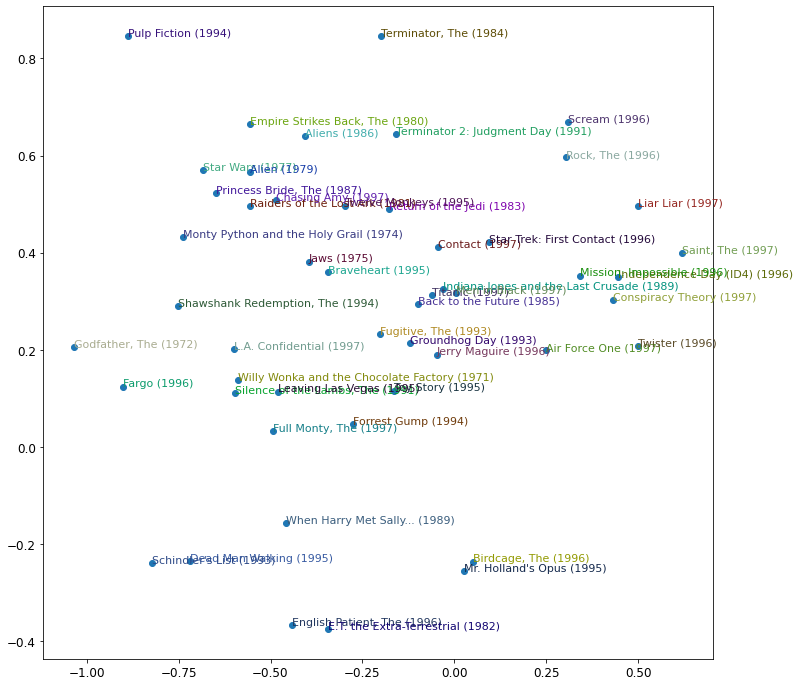

In [44]:
#hide_input
#id img_pca_movie
#caption Representation of movies based on two strongest PCA components
#alt Representation of movies based on two strongest PCA components
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes['title'].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0,fac1,fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12,12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

Bu concept çok değerli, yani çok basit bir mantıkla eğitilen model filmler hakkında belki de kimsenin bilmediği bilgileri öğreniyor. Filmleri uzayda öyle bir yerleştiriyor ki belki insanların anlayamadığı ilişkileri yakalıyor.

## Using Fastai Colab

Yukarıda bir collaborative filtering modelini kendimiz nerdeyse sıfırdan oluşturmuş olduk, böylece mantığını daha iyi kavradık. Ancak elbette fastai bizim için bu işleri çok daha pratik biçimde yapabiliyor.

ColabDataLoaders ile oluşturulan dls'den sonra sadece factor sayısını ve output aralığını colab_learner'a besleriz, model otomatik olarak dls'teki kullanıcı ve item sayısına göre weight matrix'leri set eder, forward propagation için gerekli modeli set eder vesaire:

In [45]:
#Tek satırda learner'ı yaratırız:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

In [46]:
#Hemen fit edebiliriz:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.942572,0.959911,00:17
1,0.843274,0.876878,00:17
2,0.723817,0.833800,00:17
3,0.599769,0.819157,00:18
4,0.479690,0.819610,00:14


In [47]:
#Modelin layers'ını detaylı görelim:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 50)
  (i_weight): Embedding(1665, 50)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1665, 1)
)

Bu layer'ların isimlerini kullanarak daha önceki kısımlarda yapılan analizleri yapabiliriz, örneğin model içindeki movie bias'a ulaşmak için i_bias'a ulaşırız, aşağıdaki gibi bias analizini yapabiliriz:

In [48]:
movie_bias = learn.model.i_bias.weight.squeeze()
idxs = movie_bias.argsort(descending=True)[:5]
[dls.classes['title'][i] for i in idxs]

['L.A. Confidential (1997)',
 'Titanic (1997)',
 'Shawshank Redemption, The (1994)',
 'Silence of the Lambs, The (1991)',
 'Rear Window (1954)']

## Embedding Distance

Another interesting thing we can do with these learned embeddings is to look at distance.

2D bir düzlemde iki nokta arasındaki uzaklığı hesaplamak için pisagor formülünü kullanabiriz: $\sqrt{x^{2}+y^{2}}$.  Burada **x** ve **y** her axis için iki nokta arasındaki doğrusal uzaklığı temsil ediyor.

50D uzayda da aynı formül işler, sadece 2 tane kare yerine 50 tane kare toplanacak.

Eğer iki filmin karakteristikleri çok benzerse, demek ki embedding vectors'u de çok benzer olacak. O halde embedding distance'ın az olması demek iki filmin karakteristiklerinin birbirine yakın olması demektir. 

Bu mantıkla ben mesela *Silence of the Lambs* filmi gibi bir film arıyorum dediğim zaman, ilgili filmin embedding'ine en yakın embedding'i arıyorum demek istiyorum bunu da basitçe min distance'ı bularak bulabilirim.

In [49]:
movie_factors = learn.model.i_weight.weight
idx = dls.classes['title'].o2i['Silence of the Lambs, The (1991)']
distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx][None])
idx = distances.argsort(descending=True)[1]
dls.classes['title'][idx]

'Farewell to Arms, A (1932)'

Artık modelimizi eğittik, bu modeli farklı amaçlarla kullanabiliriz. Peki yeni kullanıcılara nasıl recommendation yapacağız? Sonuçta yeni kullanıcılar taste profili elimizde olmayacak.

## Bootstrapping a Collaborative Filtering Model

Collaborative filtering modellerinin en önemli problemi **bootstrapping problem**. Bu problemin extreme version'ı şu: elimizde hiç kullanıcı olmayabilir, dolayısıyla modelimizin kullanıcı ve film embeddings'lerini öğrenebileceği bir dataset'i yok. Bu durumda ilk kullanıcına hangi item'ı önereceksin?

Belki bu çok uç bir örnek oldu ama diyelim ki, elinde datan vesaire var modelini eğittin kullanıcıların ve filmlerin taste profile'ı oluştu, şimdi yeni bir kullanıcı geldi buna ne önereceksin? Yeni kullanıcının taste profile'ı hakkında elinde hiçbir veri yok ki! Ya da benzer şekilde, diyelim ki yeni bir film geldi, filmi henüz kimse izlemedi elinde filmin characteristics'i yok o halde kim buna ne puan verir tahmin edemiyorsun. Ne olacak?

Bu problemin kesin bir çözümü yok, yapılabilecek bazı şeyler var. Örneğin bir yöntem şu olabilir, yeni kullanıcıya başlangıçta tüm embeddings'in ortalamasını atayabiliriz. Ancak sanıyorum bunun problemi şu, böyle ortalama alırsak sci-fi ortalaması yüksek ve action ortalaması düşük çıkabilir, genelin ortalaması bu ancak bunu tek bir kişiye atarsak absurd bir kişi yaratmış oluyoruz, yani sci-fi sevip action sevmeyen biri yarattık bu average bir tiğ değil. Bunun yerine **average taste**'li bir user seçip kullanıcıya da bu taste profile'ı atamak daha iyi olabilir.

Daha iyi bir yöntem şu olabilir, kullanıcıların initial embedding vector'ünü oluşturmak için kullanıcıdan alınacak meta data ile bir tabular model kullanmak. Yani mesela kullanıcılar kayıt olurken, onlardan ne tür filmler seversin, kaç yaşındasın vesaire gibi film zevkine etki edeceğini düşündüğümüz bilgileri alırız, bu bilgileri bir tabular modele input olarak veririz, output olarak da embeddings çıkar. Elbette bu modeli eğitmek için elimizde daha önceden bu bilgileri doldurmuş, ve embedding'leri halihazırda oturmuş kullanıcılar lazım.


One thing to be careful of is that a small number of extremely enthusiastic users may end up effectively setting the recommendations for your whole user base. This is a very common problem, for instance, in movie recommendation systems. People that watch anime tend to watch a whole lot of it, and don't watch very much else, and spend a lot of time putting their ratings on websites. As a result, anime tends to be heavily overrepresented in a lot of *best ever movies* lists. In this particular case, it can be fairly obvious that you have a problem of representation bias, but if the bias is occurring in the latent factors then it may not be obvious at all.

Such a problem can change the entire makeup of your user base, and the behavior of your system. This is particularly true because of positive feedback loops. If a small number of your users tend to set the direction of your recommendation system, then they are naturally going to end up attracting more people like them to your system. And that will, of course, amplify the original representation bias. This type of bias has a natural tendency to be amplified exponentially. You may have seen examples of company executives expressing surprise at how their online platforms rapidly deteriorated in such a way that they expressed values at odds with the values of the founders. In the presence of these kinds of feedback loops, it is easy to see how such a divergence can happen both quickly and in a way that is hidden until it is too late.

In a self-reinforcing system like this, we should probably expect these kinds of feedback loops to be the norm, not the exception. Therefore, you should assume that you will see them, plan for that, and identify up front how you will deal with these issues. Try to think about all of the ways in which feedback loops may be represented in your system, and how you might be able to identify them in your data. In the end, this is coming back to our original advice about how to avoid disaster when rolling out any kind of machine learning system. It's all about ensuring that there are humans in the loop; that there is careful monitoring, and a gradual and thoughtful rollout.

Our dot product model works quite well, and it is the basis of many successful real-world recommendation systems. This approach to collaborative filtering is known as **probabilistic matrix factorization** (PMF). Another approach, which generally works similarly well given the same data, is deep learning.

## Deep Learning for Collaborative Filtering

Dot Product modelimiz bir çok collaborative filtering porblemi için gerçekte de kullanılır, buna bir alternatif ise Deep Learning yöntemidir. Şimdi buna bakacağız.

Architecture'ımızı deep learning model'e çevirmek için yapacağımız ilk şey embedding'leri birbiri ile elementwise çarpıp toplamak yerine onları concatenate etmek. Bildiğimiz ucuca eklemekten bahsediyoruz, böylece bu embeddingleri input olarak alıp bir NN'e besleyebiliriz output olarak da rating bekleyebiliriz.

Eskiden dot product yaptığımız için latent factor sayısı hem users hem de items için aynı olmak zorundaydı, fakat artık bu şart değil farklı embedding size seçilebilir.

Peki hangi embedding size'ı seçeceğimize nasıl karar verebiliriz, bunun için fastai `get_emb_sz` fonksiyonunu kullanabiliriz. Bu fonksiyon deneme yanılmaya dayalı olarak embedding matrices için recommended sizes retun edecektir.

In [50]:
#Gördüğümüz gibi dataloaders'ı fonksiyona besliyoruz.
#Sonuçta user sayısı ve movie sayısı dikkate alınarak recommended embedding matrix sizes return ediliyor.
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

Şimdi sırada modelimizi oluşturmak var, modelimiz içerisinde Embedding class'ı kullanılarak, embedding matrices initialize edilecek, ardından bir NN tanımlanacak bu NN içerisinde 3 layer var, ilk layer concataneted embedding vector'ü alıp, 100 tane activation çıkarıyor, daha sonra buna ReLU activation uygulanıyor sonra da 100 activation Linear layer'a alınıp tek bir output çıktı olarak veriliyor.

Forward içerisinde de önce batch_size kadar yani 64 tane embeddings alınıp concatanete ediliyor sonra da bu concat edilen 64 vektör layers içerisine besleniyor böylece her bir datapoint için bir output hesaplanmış olacak, son olarak bu 64 output sigmoid_range fonksiyonu içerisine beslenerek 0-5 arası bir output elde etmek bekleniyor.

In [52]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0,5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.layers = nn.Sequential(
            nn.Linear(user_sz[1]+item_sz[1], n_act),
            nn.ReLU(),
            nn.Linear(n_act, 1))
        self.y_range = y_range
        
    def forward(self, x):
        embs = self.user_factors(x[:,0]),self.item_factors(x[:,1])
        x = self.layers(torch.cat(embs, dim=1))
        return sigmoid_range(x, *self.y_range)

Bu classta dikkatimi çeken şey şu, bazı parametreler * ile geçiriliyor, örneğin Embedding içerisine iki parametre alıyor ama biz *user_sz geçiriyoruz, user_sz (944,74) olacak yani * ile geçirince sanki ayrı ayrı geçirmiş gibi oluyoruz. Zaten bu user_sz'ı geçirmek için de aşağıda göreceğiz CollabNN içerisine *embs geçirilecek yani embs'in ilk tuple'ı user_sz olarak geçirilecek ikinci tuple'ı da item_sz olarak.

Modeli yaratalım:

In [53]:
model = CollabNN(*embs)

CollabNN creates our Embedding layers in the same way as previous classes in this chapter, except that we now use the embs sizes. self.layers is identical to the mini-neural net we created for MNIST. Then, in forward, we apply the embeddings, concatenate the results, and pass this through the mini-neural net. Finally, we apply sigmoid_range as we have in previous models.

Train edelim:

In [54]:
learn = Learner(dls, model, loss_func=MSELossFlat())
learn.fit_one_cycle(5, 5e-3, wd=0.01)

epoch,train_loss,valid_loss,time
0,0.945964,0.955434,00:11
1,0.914564,0.898798,00:11
2,0.850709,0.882731,00:11
3,0.814893,0.873422,00:11
4,0.762208,0.874865,00:11


Yukarıdaki gibi dls'i kullanarak embedding sizes'ı bulup, bir CollabNN modeliniz kendimiz oluşturup, instantiate edip, learnet'a beslemek yerine aynı işlemleri bizim için yapacak daha kısa fastai yöntemi de var:

In [55]:
#collab_learner içerisinde use_nn=True dediğimizde yukarıdaki işlemler yapılacaktır.
#ayrıca layers'ı aşağıdaki gibi belirtip architecture'ı customize edebiliriz.
learn = collab_learner(dls, use_nn=True, y_range=(0, 5.5), layers=[100,50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,1.004835,1.000878,00:17
1,0.882616,0.930778,00:15
2,0.883307,0.898800,00:14
3,0.815728,0.869480,00:14
4,0.799966,0.868087,00:14


In [56]:
#learner'ımızın kullandığı modele göz atalım:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(944, 74)
    (1): Embedding(1665, 102)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): BatchNorm1d(176, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=176, out_features=100, bias=False)
      (2): ReLU(inplace=True)
    )
    (1): LinBnDrop(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=50, bias=False)
      (2): ReLU(inplace=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): SigmoidRange(low=0, high=5.5)
  )
)

Görüyoruz ki learn.model is an object of type EmbeddingNN. Bu EmbeddingNN class'ına bir göz atalım, bakalım bu modeli nasıl oluşturuyor, bu collabNN gibi bir şey olmalı:

In [57]:
@delegates(TabularModel)
class EmbeddingNN(TabularModel):
    def __init__(self, emb_szs, layers, **kwargs):
        super().__init__(emb_szs, layers=layers, n_cont=0, out_sz=1, **kwargs)

Görüyoruz ki bu class TabularModel'in bir child'ı, hatta neredeyse hiçbir ekstrası yok, constructor'ında bile super'inin consturctor'ını çağırıyor, sadece ilgili parametreleri geçiriyor, n_cont=0 ve out_sz=1 olarak atanıyor o kadar.

### Sidebar: kwargs and Delegates

`EmbeddingNN` includes `**kwargs` as a parameter to `__init__`. In Python `**kwargs` in a parameter list means "put any additional keyword arguments into a dict called `kwargs`. And `**kwargs` in an argument list means "insert all key/value pairs in the `kwargs` dict as named arguments here". This approach is used in many popular libraries, such as `matplotlib`, in which the main `plot` function simply has the signature `plot(*args, **kwargs)`. The [`plot` documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.plot) says "The `kwargs` are `Line2D` properties" and then lists those properties.

We're using `**kwargs` in `EmbeddingNN` to avoid having to write all the arguments to `TabularModel` a second time, and keep them in sync. However, this makes our API quite difficult to work with, because now Jupyter Notebook doesn't know what parameters are available. Consequently things like tab completion of parameter names and pop-up lists of signatures won't work.

fastai resolves this by providing a special `@delegates` decorator, which automatically changes the signature of the class or function (`EmbeddingNN` in this case) to insert all of its keyword arguments into the signature.

### End sidebar

Sonuç olarak `EmbeddingNN` modelinin performansı dot product yaklaşımından bi tık daha kötü olsa da bu yaklaşımın önemli bir getirisi var.

Bu tip bir model ile artık sadece user_id ve movie_id verilerini kullanmakla sınırlı kalmak zorunda değiliz daha farklı user ve movie bilgilerininin yanında date time gibi bilgileri de deep learning yaklaşımında modele dahil edebiliriz, önceden böyle bir imkanımız yoktu.

Zaten `TabularModel` dediğimiz şey de tam olarak bunu yapar, zaten gördük ki: `EmbeddingNN` is just a `TabularModel`, with `n_cont=0` and `out_sz=1`.

Önümüzdeki chapter'da we'll spend some time learning about `TabularModel`, and how to use it to get great results!